In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv
/kaggle/input/deep-learning-for-msc-202324/sample.csv
/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv
/kaggle/input/deep-learning-for-msc-202324/labels_train.csv
/kaggle/input/deep-learning-for-msc-202324/test/1OGQ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1NHI_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1R1H_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1VL5_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1JLI_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1JAD_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1R73_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1WU9_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1PAQ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1XPP_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1EZJ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/te

In [ ]:
pip install ax-platform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguar

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from ax.service.managed_loop import optimize
import matplotlib.pyplot as plt


# **Creation of custom dataset class for protein structure prediction**

In [ ]:
class TrainEvalProteinStructureDataset(Dataset):
    def __init__(self, seqs_df, labels_df, pssm_dir, augment=False, shuffle_rate=0.1, segment_length=5, amino_acids='ACDEFGHIKLMNPQRSTVWY'):
        self.seqs_df = seqs_df
        self.labels_df = labels_df
        self.pssm_dir = pssm_dir
        self.augment = augment
        self.shuffle_rate = shuffle_rate
        self.segment_length = segment_length
        self.amino_acids = amino_acids
        self.label_to_idx = {'H': 0, 'E': 1, 'C': 2}

    # This method performs sequence shuffling. Initially I analyzed the model was overfitting,
    # To address this issue data augementation was performed to boost the diversity of the
    # training data by creating several orderings of the sequences. By doing this, the model
    # may be able to learn more resilient patterns rather than memorizing particular sequences.
    def shuffle_sequence(self, sequence):
        if not self.augment:
            return sequence
        sequence = list(sequence)
        for _ in range(int(len(sequence) * self.shuffle_rate)):
            start_idx = np.random.randint(0, len(sequence) - self.segment_length)
            segment = sequence[start_idx:start_idx + self.segment_length]
            np.random.shuffle(segment)
            sequence[start_idx:start_idx + self.segment_length] = segment
        return ''.join(sequence)

    # This method is utilized for one-hot encoding of amino acids.
    def one_hot_encode_aa(self, sequence):
        aa_to_idx = {aa: i for i, aa in enumerate(self.amino_acids)}
        one_hot = np.zeros((len(sequence), len(self.amino_acids)), dtype=np.float32)
        for i, aa in enumerate(sequence):
            if aa in aa_to_idx:
                one_hot[i, aa_to_idx[aa]] = 1.0
        return one_hot

    # This method encode's secondary structure labels
    def encode_labels(self, labels):
        return np.array([self.label_to_idx[label] for label in labels], dtype=np.int64)

    def __len__(self):
        return len(self.seqs_df)

    def __getitem__(self, idx):
        pdb_id = self.seqs_df.iloc[idx]['PDB_ID']
        sequence = self.shuffle_sequence(self.seqs_df.iloc[idx]['SEQUENCE'])
        labels = self.labels_df[self.labels_df['PDB_ID'] == pdb_id]['SEC_STRUCT'].values[0]
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_train.csv")

        # Drops irrelevant columns ('RES_NUM', 'AMINO_ACID').
        pssm_data = pd.read_csv(pssm_path).drop(columns=['RES_NUM', 'AMINO_ACID']).values

        #Adds a small epsilon value (1e-7) to the denominator to avoid division by zero.
        epsilon = 1e-7

        #Normalizes the data by subtracting the mean and dividing by the standard deviation
        #to ensure numerical stability.
        pssm_data = (pssm_data - pssm_data.mean(axis=0)) / (pssm_data.std(axis=0) + epsilon)

        sequence_encoded = self.one_hot_encode_aa(sequence)
        labels_encoded = self.encode_labels(labels)

        #Determines the minimum length among the encoded sequence, PSSM data, and labels.
        #Truncates all data arrays to this minimum length to ensure consistency.
        min_len = min(len(sequence_encoded), len(pssm_data), len(labels_encoded))
        sequence_encoded = sequence_encoded[:min_len]
        pssm_data = pssm_data[:min_len]
        labels_encoded = labels_encoded[:min_len]

        #Concatenates the one-hot encoded sequence and PSSM data horizontally to create
        #the feature vector for the sample.
        features = np.hstack([sequence_encoded, pssm_data])
        return torch.tensor(features, dtype=torch.float), torch.tensor(labels_encoded, dtype=torch.long)

In [ ]:
# Define the model class
class FullyConvolutionalNetwork(nn.Module):
    def __init__(self, input_channels, output_channels, num_filters):
        super(FullyConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=num_filters, out_channels=output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x


In [ ]:
#This method ensures that all data samples within a batch have the same length by
#padding them appropriately
def custom_padder(batch):
    batch_features, batch_labels = zip(*batch)
    max_length = max([len(features) for features in batch_features])
    padded_features = [F.pad(features, (0, 0, 0, max_length - len(features))) for features in batch_features]
    padded_labels = [F.pad(labels, (0, max_length - len(labels)), value=-1) for labels in batch_labels]
    batch_features_tensor = torch.stack(padded_features)
    batch_labels_tensor = torch.stack(padded_labels)
    return batch_features_tensor, batch_labels_tensor

#  **Data Preparation**

In [ ]:
# Loading the data
seqs_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv')
labels_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/labels_train.csv')
pssm_dir = '/kaggle/input/deep-learning-for-msc-202324/train'

# Split the dataset into training and validation sets
train_seqs_df, val_seqs_df, train_labels_df, val_labels_df = train_test_split(seqs_df, labels_df, test_size=0.2, random_state=42)

# Create datasets
train_dataset = TrainEvalProteinStructureDataset(train_seqs_df, train_labels_df, pssm_dir, augment=True)
val_dataset = TrainEvalProteinStructureDataset(val_seqs_df, val_labels_df, pssm_dir)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_padder)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_padder)

# **Train and evaluate method without hyperparameter optimization**

Epoch 1/10, Training Accuracy: 0.6751, Training Loss: 0.7500, Validation Accuracy: 0.7272, Validation Loss: 0.6594
Epoch 2/10, Training Accuracy: 0.7338, Training Loss: 0.6417, Validation Accuracy: 0.7444, Validation Loss: 0.6218
Epoch 3/10, Training Accuracy: 0.7473, Training Loss: 0.6116, Validation Accuracy: 0.7492, Validation Loss: 0.6099
Epoch 4/10, Training Accuracy: 0.7552, Training Loss: 0.5940, Validation Accuracy: 0.7547, Validation Loss: 0.5959
Epoch 5/10, Training Accuracy: 0.7589, Training Loss: 0.5845, Validation Accuracy: 0.7580, Validation Loss: 0.5862
Epoch 6/10, Training Accuracy: 0.7625, Training Loss: 0.5780, Validation Accuracy: 0.7626, Validation Loss: 0.5761
Epoch 7/10, Training Accuracy: 0.7665, Training Loss: 0.5678, Validation Accuracy: 0.7645, Validation Loss: 0.5726
Epoch 8/10, Training Accuracy: 0.7682, Training Loss: 0.5645, Validation Accuracy: 0.7666, Validation Loss: 0.5663
Epoch 9/10, Training Accuracy: 0.7686, Training Loss: 0.5628, Validation Accurac

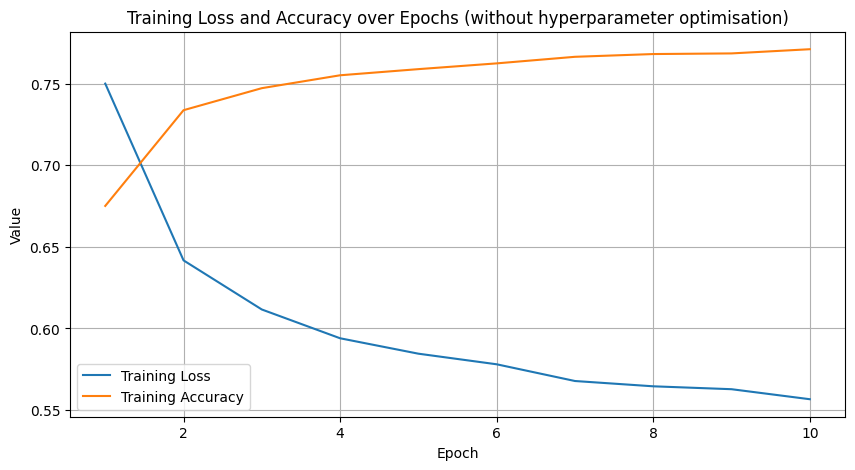

In [ ]:
# Model1 instantiation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = FullyConvolutionalNetwork(input_channels=40, output_channels=3, num_filters=64).to(device)

# Training and validation loop
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

train_losses = []
train_accuracies=[]

# Training and Validation Loop for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model1.train()
    total_train_correct = 0
    total_train_samples = 0
    total_train_loss = 0

    for sequences, labels in train_loader:
        sequences = sequences.transpose(1, 2).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model1(sequences).transpose(1, 2)

        loss = criterion(predictions.reshape(-1, 3), labels.flatten())
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions, 2)
        valid_indices = labels != -1
        total_train_correct += (predicted[valid_indices] == labels[valid_indices]).sum().item()
        total_train_samples += valid_indices.sum().item()
        total_train_loss += loss.item()

    train_accuracy = total_train_correct / total_train_samples
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model1.eval()
    total_val_correct = 0
    total_val_samples = 0
    total_val_loss = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.transpose(1, 2).to(device)
            labels = labels.to(device)
            predictions = model1(sequences).transpose(1, 2)

            _, predicted = torch.max(predictions, 2)
            valid_indices = labels != -1
            total_val_correct += (predicted[valid_indices] == labels[valid_indices]).sum().item()
            total_val_samples += valid_indices.sum().item()

            loss = criterion(predictions.reshape(-1, 3), labels.flatten())
            total_val_loss += loss.item()

    val_accuracy = total_val_correct / total_val_samples
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.4f}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plotting the training loss and training accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy over Epochs (without hyperparameter optimisation)')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of above model:
* There is no significant gap between training and validation metrics.
* Both training and validation accuracies are increasing while losses are decreasing, indicating that the model is learning and improving.
* But the accuracy is upto 80% also, so further we are going to use hyperparameter optimisation of push the accuracy further for both training and validation set.

# **Train and evaluate method for hyperparameter optimization with Ax.**

In [ ]:
def train_evaluate(parameterization):
    # Model instantiation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FullyConvolutionalNetwork(input_channels=40, output_channels=3, num_filters=parameterization["num_filters"]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=parameterization["lr"])
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    for epoch in range(3):  # Using 3 epochs for quick evaluation
        model.train()
        for sequences, labels in train_loader:
            sequences = sequences.transpose(1, 2).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            predictions = model(sequences).transpose(1, 2)
            loss = criterion(predictions.reshape(-1, 3), labels.flatten())
            loss.backward()
            optimizer.step()

    # Simplified validation for hyperparameter optimization
    model.eval()
    total_val_correct = 0
    total_val_samples = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.transpose(1, 2).to(device)
            labels = labels.to(device)
            predictions = model(sequences).transpose(1, 2)
            _, predicted = torch.max(predictions, 2)
            valid_indices = labels != -1
            total_val_correct += (predicted[valid_indices] == labels[valid_indices]).sum().item()
            total_val_samples += valid_indices.sum().item()

    val_accuracy = total_val_correct / total_val_samples
    return val_accuracy

In [ ]:
# Only optimising lr and num_filters hyperparameters with Ax
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 1e-1], "log_scale": True},
        {"name": "num_filters", "type": "range", "bounds": [32, 128]},
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
    total_trials=10
)

print("Best parameters:", best_parameters)

[INFO 03-18 12:55:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 12:55:50] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter num_filters. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 12:55:50] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.1], log_scale=True), RangeParameter(name='num_filters', parameter_type=INT, range=[32, 128])], parameter_constraints=[]).
[INFO 03-18 12:55:50] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 03-18 12:55:50] ax.modelbr

Best parameters: {'lr': 0.0040865855726099805, 'num_filters': 98}


# **Training and Validation using the best parameters from the optimization**

Epoch 1/10, Training Accuracy: 0.7082, Training Loss: 0.6885, Validation Accuracy: 0.7384, Validation Loss: 0.6323
Epoch 2/10, Training Accuracy: 0.7581, Training Loss: 0.5871, Validation Accuracy: 0.7550, Validation Loss: 0.5962
Epoch 3/10, Training Accuracy: 0.7664, Training Loss: 0.5673, Validation Accuracy: 0.7685, Validation Loss: 0.5604
Epoch 4/10, Training Accuracy: 0.7714, Training Loss: 0.5561, Validation Accuracy: 0.7740, Validation Loss: 0.5497
Epoch 5/10, Training Accuracy: 0.7754, Training Loss: 0.5472, Validation Accuracy: 0.7742, Validation Loss: 0.5497
Epoch 6/10, Training Accuracy: 0.7782, Training Loss: 0.5420, Validation Accuracy: 0.7767, Validation Loss: 0.5453
Epoch 7/10, Training Accuracy: 0.7813, Training Loss: 0.5346, Validation Accuracy: 0.7696, Validation Loss: 0.5601
Epoch 8/10, Training Accuracy: 0.7818, Training Loss: 0.5326, Validation Accuracy: 0.7776, Validation Loss: 0.5415
Epoch 9/10, Training Accuracy: 0.7858, Training Loss: 0.5242, Validation Accurac

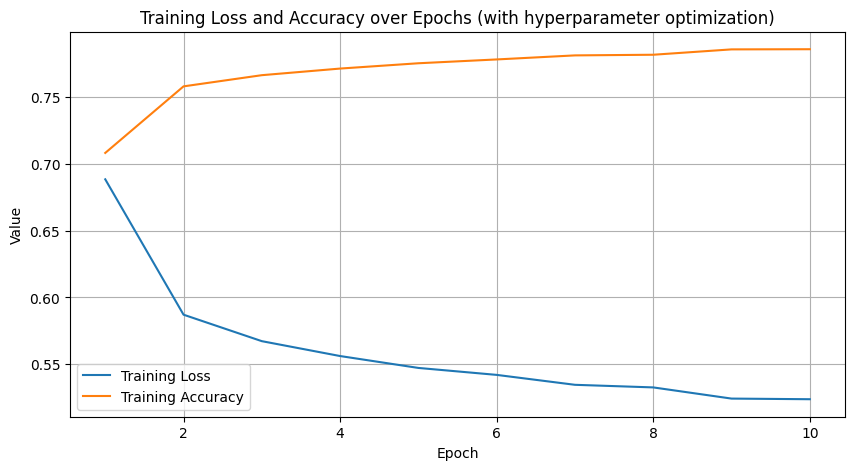

In [ ]:
optimized_lr = best_parameters["lr"]
optimized_num_filters = int(best_parameters["num_filters"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConvolutionalNetwork(input_channels=40, output_channels=3, num_filters=optimized_num_filters).to(device)

# Settingup optimizer with the optimized learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=optimized_lr)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

train_losses = []
train_accuracies=[]

# Training and Validation Loop for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_correct = 0
    total_train_samples = 0
    total_train_loss = 0

    for sequences, labels in train_loader:
        sequences = sequences.transpose(1, 2).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(sequences).transpose(1, 2)

        loss = criterion(predictions.reshape(-1, 3), labels.flatten())
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions, 2)
        valid_indices = labels != -1
        total_train_correct += (predicted[valid_indices] == labels[valid_indices]).sum().item()
        total_train_samples += valid_indices.sum().item()
        total_train_loss += loss.item()

    train_accuracy = total_train_correct / total_train_samples
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    total_val_correct = 0
    total_val_samples = 0
    total_val_loss = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.transpose(1, 2).to(device)
            labels = labels.to(device)
            predictions = model(sequences).transpose(1, 2)

            _, predicted = torch.max(predictions, 2)
            valid_indices = labels != -1
            total_val_correct += (predicted[valid_indices] == labels[valid_indices]).sum().item()
            total_val_samples += valid_indices.sum().item()

            loss = criterion(predictions.reshape(-1, 3), labels.flatten())
            total_val_loss += loss.item()

    val_accuracy = total_val_correct / total_val_samples
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.4f}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plotting the training loss and training accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy over Epochs (with hyperparameter optimization)')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of the above model:
* The model is learning and getting better as seen by the increasing training and validation accuracies throughout epochs. Since there is no discernible difference between the validation and training accuracies, overfitting may not be a major problem.
* It's promising that training and validation losses are declining over epochs. The fact that the two metrics do not significantly differ further indicates that the model is doing a good job of generalizing to new data.


# **Testing**

# # Note:  
1. I have explicitly written the values of the hyperparameters in **model1**.
2. In **model**, the optimized hyperparameters are utilized.

For testing, the optimized hyperparameters **model** is utilized
       

In [ ]:
# Defining custom dataset class for testing protein structure prediction
class TestProteinStructureDataset(Dataset):
    def __init__(self, seqs_df, pssm_dir, amino_acids='ACDEFGHIKLMNPQRSTVWY'):
        self.seqs_df = seqs_df
        self.pssm_dir = pssm_dir
        self.amino_acids = amino_acids

    #This method implements One-hot encoding for amino acid sequence.
    def one_hot_encode_aa(self, sequence):
        aa_to_idx = {aa: i for i, aa in enumerate(self.amino_acids)}
        one_hot = np.zeros((len(sequence), len(self.amino_acids)), dtype=np.float32)
        for i, aa in enumerate(sequence):
            if aa in aa_to_idx:
                one_hot[i, aa_to_idx[aa]] = 1.0
        return one_hot

    def __len__(self):
        return len(self.seqs_df)

    #Using similar method from  TrainEvalProteinStructureDataset class. But no need of usage of labels here.
    def __getitem__(self, idx):
        pdb_id = self.seqs_df.iloc[idx]['PDB_ID']
        sequence = self.seqs_df.iloc[idx]['SEQUENCE']
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_test.csv")

        pssm_data = pd.read_csv(pssm_path).drop(columns=['RES_NUM', 'AMINO_ACID']).values
        epsilon = 1e-7
        pssm_data = (pssm_data - pssm_data.mean(axis=0)) / (pssm_data.std(axis=0) + epsilon)

        sequence_encoded = self.one_hot_encode_aa(sequence)

        min_len = min(len(sequence_encoded), len(pssm_data))
        sequence_encoded = sequence_encoded[:min_len]
        pssm_data = pssm_data[:min_len]

        features = np.hstack([sequence_encoded, pssm_data])
        return pdb_id, torch.tensor(features, dtype=torch.float)


# Creating the test DataLoader
seqs_test_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv')
pssm_test_dir = '/kaggle/input/deep-learning-for-msc-202324/test'
test_dataset = TestProteinStructureDataset(seqs_test_df, pssm_test_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Predict with the model
model.eval()
predictions = []

# Dictionary to map numerical labels to structural labels
label_mapping = {0: 'H', 1: 'E', 2: 'C'}

with torch.no_grad():
    for pdb_id, sequences in test_loader:
        sequences = sequences.transpose(1, 2).to(device)
        outputs = model(sequences).transpose(1, 2)
        _, predicted = torch.max(outputs, 2)
        # Convert predicted numerical labels to corresponding structural labels
        predicted_labels = ''.join([label_mapping[int(x)] for x in predicted.view(-1).cpu().numpy()])
        predictions.append((pdb_id[0], predicted_labels))

# Flatten the predictions to match the expected submission format
flat_predictions = []
for pdb_id, structure in predictions:
    for i, label in enumerate(structure, 1):
        flat_predictions.append((f"{pdb_id}_{i}", label))

# Saving the prediction in required format in submission.csv
submission_df = pd.DataFrame(flat_predictions, columns=['ID', 'STRUCTURE'])
submission_df.to_csv('submission.csv',index=False)
